In [1]:
import polars as pl
from langdetect import detect
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import re
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer



# 1 Investigate dataset:

In this first part, we will analyse the dataset in order to fully understand its properties and characteristics.

In [11]:


splits = {'train': 'openassistant_best_replies_train.jsonl', 'test': 'openassistant_best_replies_eval.jsonl'}
df_train = pd.read_json("hf://datasets/timdettmers/openassistant-guanaco/" + splits["train"], lines=True)
df_test = pd.read_json("hf://datasets/timdettmers/openassistant-guanaco/" + splits["test"], lines=True)



In [12]:
# PRINT SOME INFO
print(df_train.head(5))
print("")
print("Example first Row (train):", df_train.iloc[0]["text"])
print("Example first Row (test):", df_test.iloc[0]["text"])
print("Number of Rows total:    ", len(df_train) + len(df_test))
print("Number of Rows test:     ", len(df_test))
print("Number of Rows train:    ", len(df_train))

                                                text
0  ### Human: Can you write a short introduction ...
1  ### Human: ¿CUales son las etapas del desarrol...
2  ### Human: Can you explain contrastive learnin...
3  ### Human: I want to start doing astrophotogra...
4  ### Human: Método del Perceptrón biclásico: de...

Example first Row (train): ### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase

now we can extract other interesting parameters such as how many languages exist within and how they are distributed. To do this, we need to use existing libraries such as langdetect


Train Dataset


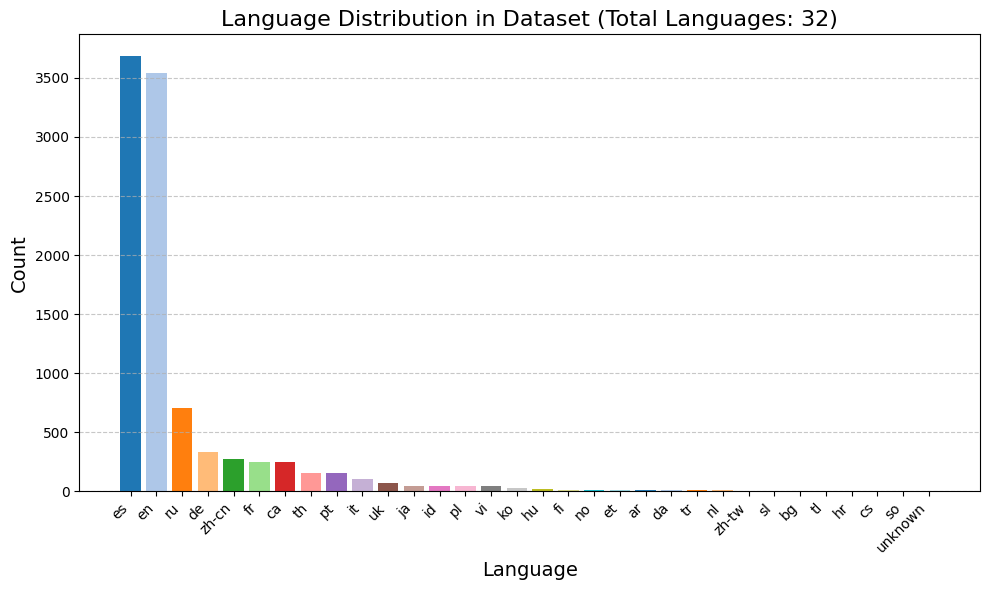

Total Languages: 32
Test Dataset


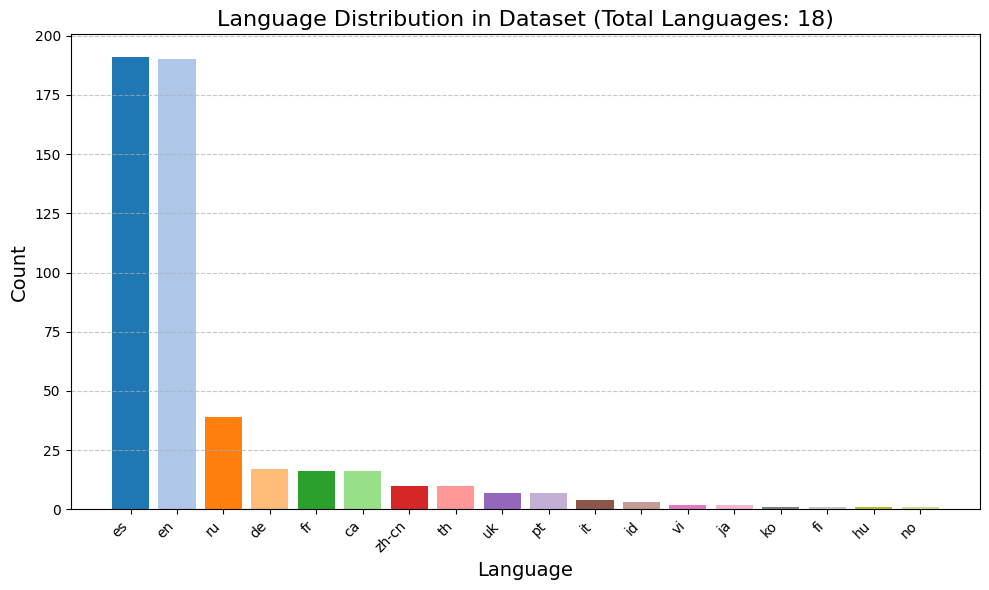

Total Languages: 18


In [13]:
def plot_language_distribution(df):
    def detect_language(text):
        try:
            return detect(text)
        except:
            return "unknown"

    df["language"] = df["text"].apply(detect_language)
    language_distribution = df["language"].value_counts().reset_index()
    language_distribution.columns = ["language", "count"]

    total_languages = language_distribution["language"].nunique()

    plt.figure(figsize=(10, 6))
    plt.bar(language_distribution["language"], language_distribution["count"], color=plt.cm.tab20.colors)
    plt.title(f"Language Distribution in Dataset (Total Languages: {total_languages})", fontsize=16)
    plt.xlabel("Language", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("Total Languages:", total_languages)

print("Train Dataset")
plot_language_distribution(df_train)
print("Test Dataset")
plot_language_distribution(df_test)


another thing we can analyse are the lengths e.g. how long on average the users' sentences are, how long the Assistant replies

In [14]:
def len_computation(df):
    def extract_human_and_assistant(text):
        try:
            human = text.split("### Assistant:")[0].replace("### Human:", "").strip()
            assistant = text.split("### Assistant:")[1].strip()
            return human, assistant
        except IndexError:
            return "", ""
        
    df["human"], df["assistant"] = zip(*df["text"].apply(extract_human_and_assistant))

    df["human_length"] = df["human"].apply(len)
    df["assistant_length"] = df["assistant"].apply(len)

    human_mean = df["human_length"].mean()
    human_std = df["human_length"].std()

    assistant_mean = df["assistant_length"].mean()
    assistant_std = df["assistant_length"].std()

    # Stampa i risultati
    print(f"mean len for human:         {human_mean:.2f},      std: {human_std:.2f}")
    print(f"mean len for Assistant:     {assistant_mean:.2f},     std: {assistant_std:.2f}")

print("Train dataset:")
len_computation(df_train)
print("")
print("Test dataset:")
len_computation(df_test)



Train dataset:
mean len for human:         122.01,      std: 248.68
mean len for Assistant:     1000.23,     std: 810.76

Test dataset:
mean len for human:         124.71,      std: 173.26
mean len for Assistant:     1014.85,     std: 886.90


we can extract the dictionary, see the number of words. To get an idea we want to see the number of different words for the whole train dataset and all words for English only

In [25]:

def extract_dictionary(df, language=None):
    def clean_text(text):
        return re.sub(r'[^\w\s]', '', text).lower()

    df['clean_text'] = df['text'].fillna('').apply(clean_text)

    word_counts = Counter()

    for text in df['clean_text']:
        if language is None or detect(text) == language:
            word_counts.update(text.split())

    return dict(word_counts)


dictionary_train = extract_dictionary(df_train)
print("Number of unique words in train dataset:", len(dictionary_train))

dictionary_train_en = extract_dictionary(df_train, language="en")
print("Number of unique words in train dataset (only english):", len(dictionary_train_en))

Number of unique words in train dataset: 155992
Number of unique words in train dataset (only english): 45492


Test just to get an idea of how many words in English there are

In [26]:
# try to remove the word that can be lemmed
stemmer = PorterStemmer()
dictionary_train_en = {stemmer.stem(word): count for word, count in dictionary_train_en.items()}
print("Number of unique words in train dataset (only english) after stemming:                                 ", len(dictionary_train_en))
lemmatizer = WordNetLemmatizer()
dictionary_train_en = {lemmatizer.lemmatize(word): count for word, count in dictionary_train_en.items()}
print("Number of unique words in train dataset (only english) after lemmatizing:                              ", len(dictionary_train_en))
dictionary_train_en = {word: count for word, count in dictionary_train_en.items() if not word.isnumeric() and word.isalpha()}
print("Number of unique words in train dataset (only english) after removing numbers and non-alphabetic words:", len(dictionary_train_en))


Number of unique words in train dataset (only english) after stemming:                                  34557
Number of unique words in train dataset (only english) after lemmatizing:                               34484
Number of unique words in train dataset (only english) after removing numbers and non-alphabetic words: 27535
